# 運転パターンの把握(右左折編: ジオマップの描画)

## データロード

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os, pathlib, math, copy
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates

In [2]:
feat_dict = {
             '11947': 'Steering_Wheel_Absolute_Angle',
             '1EF57': 'Acceleration_Sensor_Value',
             '1EF37': 'Yaw_Rate',
             '1EF61': 'Lateral_Sensor_Value',
             '1B805': 'Wheel Speed(Front Right)',
             '1B825': 'Wheel Speed(Front Left)',
             '1B845': 'Wheel Speed(Rear Right)',
             '1B865': 'Wheel Speed(Rear Left)',
             '31417': 'Vehicle_Speed'}

In [3]:
PATH_DATA_INT = pathlib.Path("../data/interim/")
PATH_DATA_PRO = pathlib.Path("../data/processed/")
PATH_DATA_PRO_SUB2 = pathlib.Path("../data/processed/subject02/")
PATH_DATA_PRO_SUB2_PKL = pathlib.Path("../data/processed/subject02/pickle")

In [5]:
def data_creation():
    colname = ['carnumber','timestamp_min','timestamp_sec','feature_name','feature_value']
    data = pd.read_csv(PATH_DATA_INT/
                       "20190605_CAN/103.486_CAR1V21_HDD2/Job1/SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv",
                       header=None,names=colname)
    data = data[data['feature_name'].isin(feat_dict.keys())]
    return(data)

data1_to_delete = data_creation()

In [6]:
data1_to_delete.head()

,carnumber,timestamp_min,timestamp_sec,feature_name,feature_value
65,21,201604200627,0.297781,31417,0.0
75,21,201604200627,0.299752,11947,-7.7
110,21,201604200627,0.304124,1B865,0.0
112,21,201604200627,0.304124,1B845,0.0
114,21,201604200627,0.304124,1B825,0.0


In [7]:
import subject2initial

pdCan_multiFiles_keyFeatures = subject2initial.pickleReadOne(
    strObj="pdCan_multiFiles_keyFeatures", myPathlib = PATH_DATA_PRO_SUB2_PKL)
pdCan_multiFiles_keyFeatures.columns = ['carnumber','timestamp_min_raw',
                                        'timestamp_sec','feature_name',
                                        'feature_value', 'timestamp_min']
data1 = copy.deepcopy(pdCan_multiFiles_keyFeatures)
data1.head()

done reading initial file
done


,carnumber,timestamp_min_raw,timestamp_sec,feature_name,feature_value,timestamp_min
27,21,201604200627,0.296461,12417,919.00,201604200627
33,21,201604200627,0.296666,12013,0.00,201604200627
47,21,201604200627,0.296912,12217,0.00,201604200627
61,21,201604200627,0.297781,31457,0.59,201604200627
65,21,201604200627,0.297781,31417,0.00,201604200627


In [8]:
for key,val in feat_dict.items():
    pdTemp = data1.query("feature_name == '" + key + "'")
    print("Key: {0}, Val: {1}, Size: {2}".format(key,val,pdTemp.shape))

Key: 11947, Val: Steering_Wheel_Absolute_Angle, Size: (366169, 6)
Key: 1EF57, Val: Acceleration_Sensor_Value, Size: (183183, 6)
Key: 1EF37, Val: Yaw_Rate, Size: (183183, 6)
Key: 1EF61, Val: Lateral_Sensor_Value, Size: (183183, 6)
Key: 1B805, Val: Wheel Speed(Front Right), Size: (366366, 6)
Key: 1B825, Val: Wheel Speed(Front Left), Size: (366366, 6)
Key: 1B845, Val: Wheel Speed(Rear Right), Size: (366366, 6)
Key: 1B865, Val: Wheel Speed(Rear Left), Size: (366366, 6)
Key: 31417, Val: Vehicle_Speed, Size: (36637, 6)


In [9]:
def intial_df_analysis(df):
    print('head of the dataframe: ')
    print(df.head())
    print('\n')

    print('shape of the dataframe: ',df.shape)
    print('\n')

    df.info()
    print('\n')
    
    print(df.describe())
    print('\n')
    
    for i in feat_dict.keys():
        print(feat_dict[i]+' - feature_value')
        print(df.loc[df.feature_name==i].feature_value.describe())
        print('\n')

In [10]:
intial_df_analysis(data1)

head of the dataframe: 
    carnumber  timestamp_min_raw  timestamp_sec feature_name  feature_value  \
27         21       201604200627       0.296461        12417         919.00   
33         21       201604200627       0.296666        12013           0.00   
47         21       201604200627       0.296912        12217           0.00   
61         21       201604200627       0.297781        31457           0.59   
65         21       201604200627       0.297781        31417           0.00   

    timestamp_min  
27   201604200627  
33   201604200627  
47   201604200627  
61   201604200627  
65   201604200627  


shape of the dataframe:  (4218493, 6)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218493 entries, 27 to 1116601
Data columns (total 6 columns):
carnumber            int64
timestamp_min_raw    int64
timestamp_sec        float64
feature_name         object
feature_value        float64
timestamp_min        int64
dtypes: float64(2), int64(3), object(1)
memory usage: 225.3

In [11]:
def adjusttime_resampling(df, freq, method):
    pd_series = []
    date_time_index = [datetime.strptime(str(df["timestamp_min"].iloc[0]), '%Y%m%d%H%M') 
                       + timedelta(seconds=x) for x in df["timestamp_sec"]]
    df.index = date_time_index

    if method == "mean":
        pd_series = df['feature_value'].resample(freq).mean()
    elif method == "sum":
        pd_series = df['feature_value'].resample(freq).sum()

    return pd_series

In [16]:
method_dict ={'sum':[],
              'mean':['1EF37','11947', '1EF57','1EF61','1B805','1B825','1B845','1B865']}

def filtered_data(df):
    initial = True
    for i in feat_dict.keys():
        if(initial):
            data_samp = pd.DataFrame(adjusttime_resampling(df[df.feature_name==i],'100L',                                                           'sum' if(i in method_dict['sum']) else 'mean'))
            data_samp.rename(columns = {'feature_value':feat_dict[i]},inplace = True) 
            initial = False
        else:
            data_samp[feat_dict[i]] = adjusttime_resampling(df[df.feature_name==i],'100L',                                                           'sum' if(i in method_dict['sum']) else 'mean')
    data_samp.dropna(inplace = True)
    return(data_samp)


In [17]:
data_sampled = filtered_data(data1)

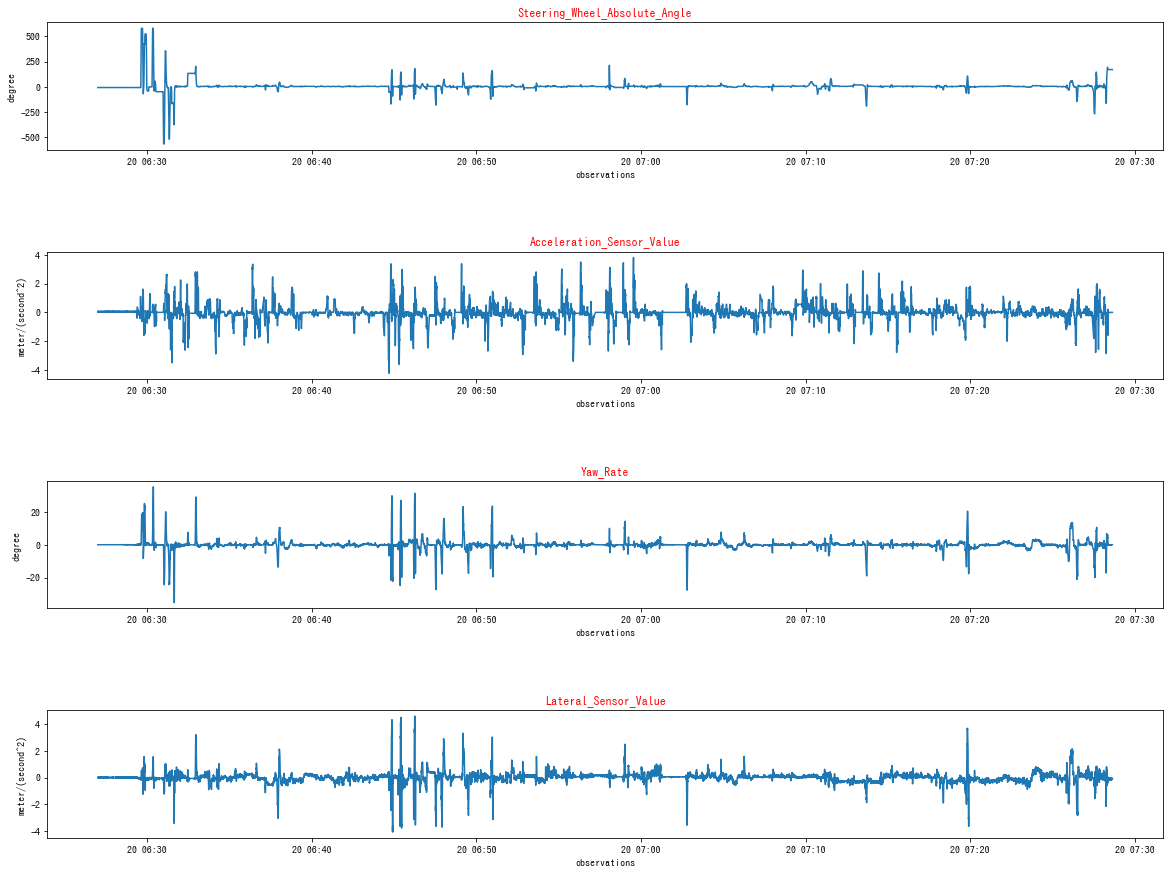

In [20]:
unit_dict = {'Steering_Wheel_Absolute_Angle':'degree',
             'Acceleration_Sensor_Value':'meter/(second^2)',
             'Yaw_Rate':'degree',
             'Lateral_Sensor_Value': 'meter/(second^2)'
            }
fig,ax = plt.subplots(len(unit_dict),1,figsize = (20,15))
plt.subplots_adjust(hspace = 0.8)

i = 0 
for key,val in unit_dict.items():
    ax[i].plot(data_sampled[key])
    ax[i].set_title(key,color = 'red')
    ax[i].set_ylabel(val)
    ax[i].set_xlabel('observations')
    i = i+1

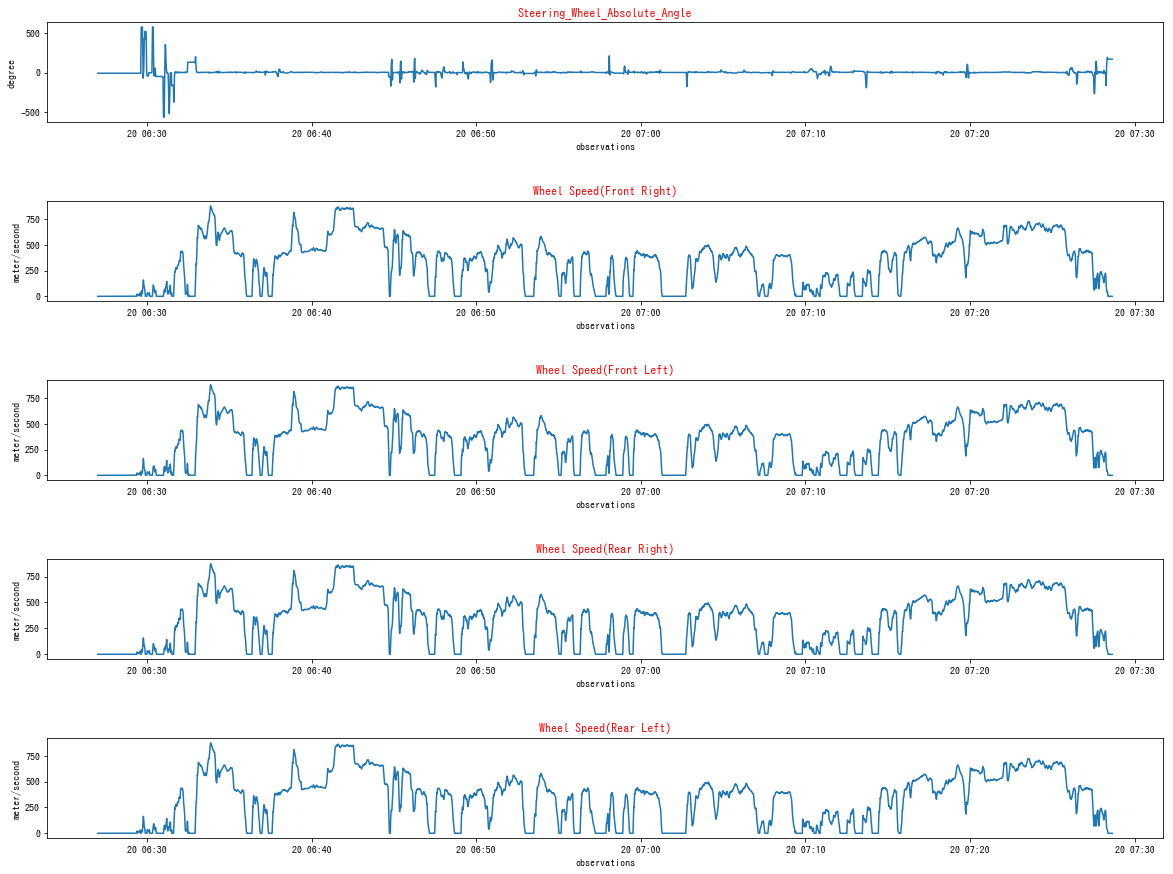

In [21]:
#%%
unit_dict = {'Steering_Wheel_Absolute_Angle':'degree',
            'Wheel Speed(Front Right)':'meter/second',
            'Wheel Speed(Front Left)':'meter/second',
            'Wheel Speed(Rear Right)':'meter/second',
            'Wheel Speed(Rear Left)':'meter/second'}
fig,ax = plt.subplots(len(unit_dict),1,figsize = (20,15))
plt.subplots_adjust(hspace = 0.8)

i = 0 
for key,val in unit_dict.items():
    ax[i].plot(data_sampled[key])
    ax[i].set_title(key,color = 'red')
    ax[i].set_ylabel(val)
    ax[i].set_xlabel('observations')
    i = i+1

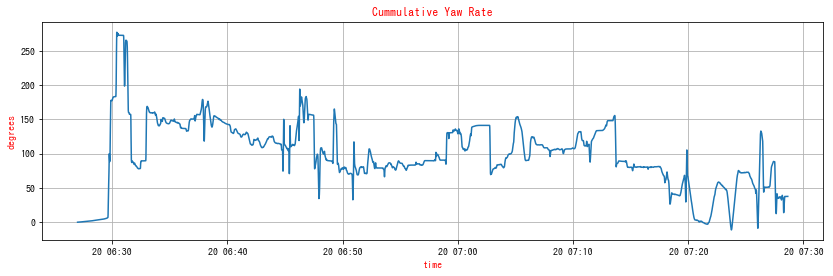

In [22]:
samplingFrequency = 10 # Since Sarang is using 100L above, sampling frequency per second is 10 times.
data_sampled['Cumm_Yaw_Rate'] = np.cumsum(data_sampled.Yaw_Rate) / samplingFrequency
plt.figure(figsize=(14,4))
plt.title('Cummulative Yaw Rate',color = 'red')
plt.ylabel('degrees', color = 'red')
plt.xlabel('time', color = 'red')
plt.plot(data_sampled['Cumm_Yaw_Rate'])
plt.grid()

In [23]:
dfCoordinate = pd.DataFrame(data_sampled[['Steering_Wheel_Absolute_Angle', 'Yaw_Rate', 'Vehicle_Speed']])

# conversion KPH into Meter Per Second = ( KPH * 1000 m ) / (1hour * 60 minutes * 60 seconds)
dfCoordinate['Vehicle_Speed_MPS']  = ( dfCoordinate['Vehicle_Speed'] * 1000) / (1 * 60 * 60)
dfCoordinate['cumu_yaw_rate']      =  np.cumsum(dfCoordinate.Yaw_Rate) / samplingFrequency
dfCoordinate['cumu_Steering_Wheel_Absolute_Angle'] =  \
    np.cumsum(dfCoordinate.Steering_Wheel_Absolute_Angle) / samplingFrequency

dfCoordinate['cos'] = np.cos(np.radians(dfCoordinate['cumu_yaw_rate'])) 
dfCoordinate['sin'] = np.sin(np.radians(dfCoordinate['cumu_yaw_rate'])) 

vecSpeed100ms = dfCoordinate['Vehicle_Speed_MPS'] * (1/samplingFrequency)

dfCoordinate['relative_x']   = dfCoordinate['cos'] * vecSpeed100ms
dfCoordinate['relative_y']   = dfCoordinate['sin'] * vecSpeed100ms
dfCoordinate['coordinate_x'] = np.cumsum(dfCoordinate['relative_x'])
dfCoordinate['coordinate_y'] = np.cumsum(dfCoordinate['relative_y'])

dfCoordinate['time_mark'] = [this100ms  for this100ms in range(len(data_sampled.index))]
dfCoordinate['minute_mark'] = ""

for ctIndex in range(len(dfCoordinate.index)):
    if ctIndex % (samplingFrequency * 60) == 0:
        dfCoordinate['minute_mark'].iloc[ctIndex] = \
            ("Minute_" + str(dfCoordinate['time_mark'].iloc[ctIndex] / (samplingFrequency * 60)) ) 

dfCoordinate.to_csv('dfCoordinate.csv')

/Users/localadmin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
# plot cumulative yaw rate
def plotWithMinutes(nameFeatureToPlot):
    ax[i].plot(dfCoordinate[nameFeatureToPlot])
    for ctIndex in range(len(dfCoordinate.index)):
        if ctIndex % (samplingFrequency * 60) == 0:
            ax[i].annotate(s = dfCoordinate['minute_mark'].iloc[ctIndex], 
                           size = 14,
                           xy = (mdates.date2num(dfCoordinate.index[ctIndex]), 
                                 dfCoordinate[nameFeatureToPlot].iloc[ctIndex]),
                           arrowprops=dict(facecolor='green', shrink=0.01),
                           rotation = 90)

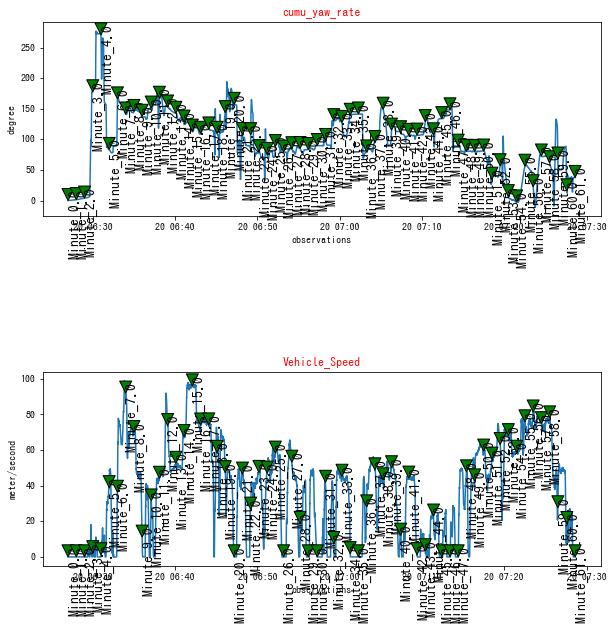

In [25]:
unit_dict = {'cumu_yaw_rate':'degree',
            'Vehicle_Speed':'meter/second'
            }
fig,ax = plt.subplots(len(unit_dict),1,figsize = (10,10))
plt.subplots_adjust(hspace = 0.8)

i = 0 
for key,val in unit_dict.items():
    plotWithMinutes(key)
    ax[i].set_title(key,color = 'red')
    ax[i].set_ylabel(val)
    ax[i].set_xlabel('observations')
    i = i+1

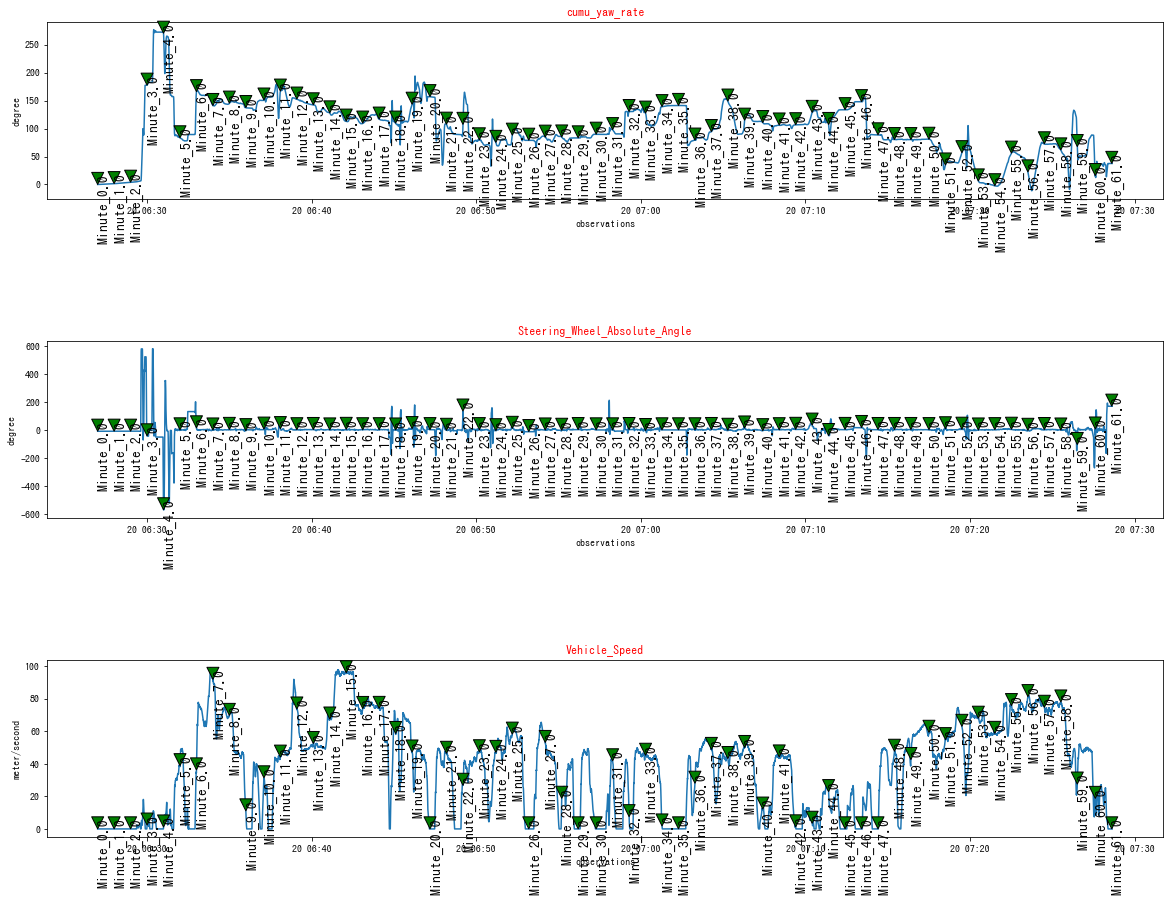

In [26]:
unit_dict = {'cumu_yaw_rate':'degree',
            'Steering_Wheel_Absolute_Angle':'degree',
            'Vehicle_Speed':'meter/second'
            }
fig,ax = plt.subplots(len(unit_dict),1,figsize = (20,15))
plt.subplots_adjust(hspace = 0.8)

i = 0 
for key,val in unit_dict.items():
    plotWithMinutes(key)
    ax[i].set_title(key,color = 'red')
    ax[i].set_ylabel(val)
    ax[i].set_xlabel('observations')
    i = i+1

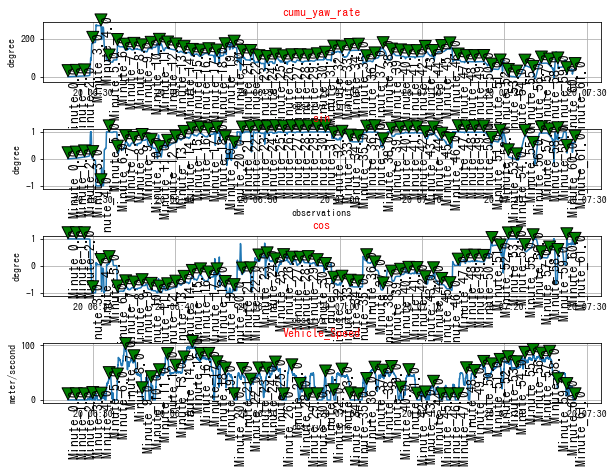

In [27]:
unit_dict = {'cumu_yaw_rate':'degree',
            'sin':'degree',
            'cos':'degree',
            'Vehicle_Speed':'meter/second'
            }

fig,ax = plt.subplots(len(unit_dict),1,figsize = (10,7))
plt.subplots_adjust(hspace = 0.8)

i = 0 
for key,val in unit_dict.items():
    plotWithMinutes(key)
    ax[i].set_title(key,color = 'red' )
    ax[i].set_ylabel(val)
    ax[i].set_xlabel('observations')
    ax[i].grid()
    i = i+1

In [29]:
def mapPlot(dfData,title, myRotation):
    # plt.figure(figsize = (10,10) )
    plt.title(title,color = 'red')
    plt.ylabel('X_Coordinates', color = 'red')
    plt.xlabel('Y_Coordinates', color = 'red')
    plt.scatter(dfData['coordinate_x'], dfData['coordinate_y'], s = 1 )
    for ctIndex in range(len(dfData.index)):
        if ctIndex % (samplingFrequency * 60) == 0:
            plt.annotate(s  = dfData['minute_mark'].iloc[ctIndex], 
                        size = 20,
                        rotation = myRotation,
                         ha='right',
                         xy = (dfData['coordinate_x'].iloc[ctIndex], 
                              dfData['coordinate_y'].iloc[ctIndex]),
                         arrowprops=dict(facecolor='green', shrink=0.2))

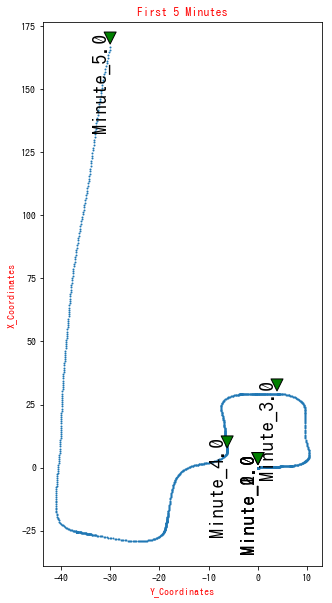

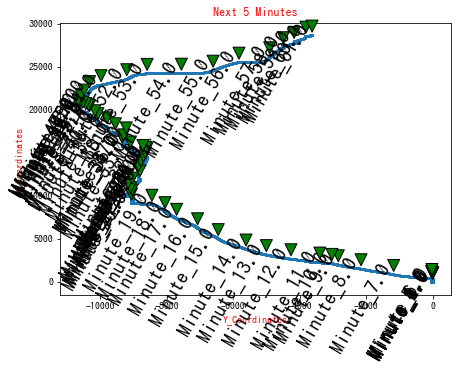

In [30]:
dfCoordinateFirstHalf = dfCoordinate.iloc[:(10*60*5+1), :] # plot only the first 6 minutes
dfCoordinateSeconHalf = dfCoordinate.iloc[(10*60*0):, :]

plt.figure(figsize = (5,10) )
mapPlot(dfCoordinateFirstHalf,'First 5 Minutes', myRotation = 90)
plt.figure(figsize = (7,5) )
mapPlot(dfCoordinateSeconHalf,'Next 5 Minutes', myRotation = 60)

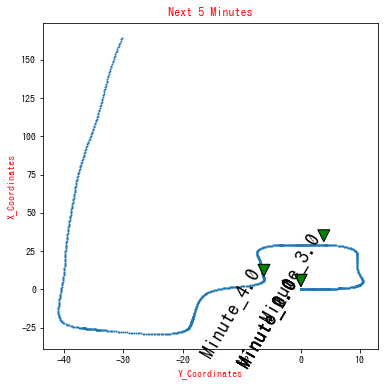

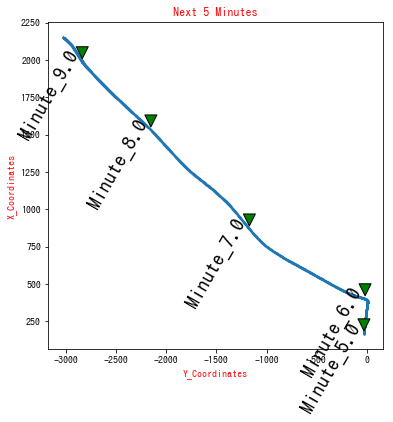

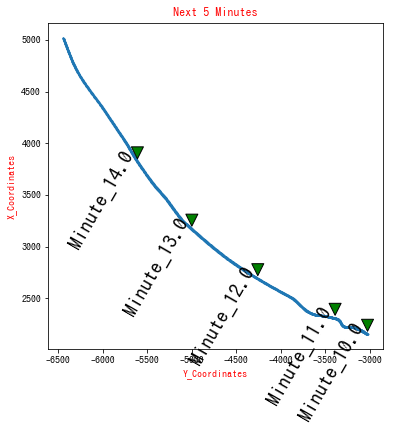

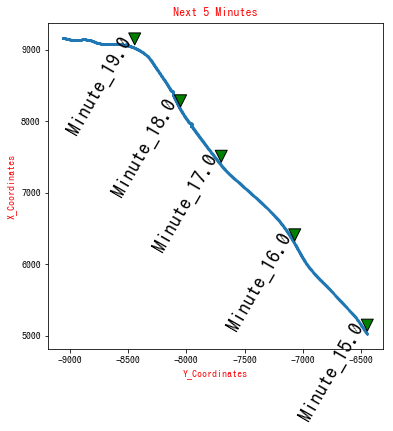

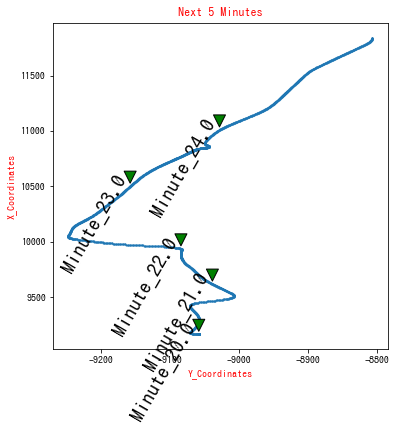

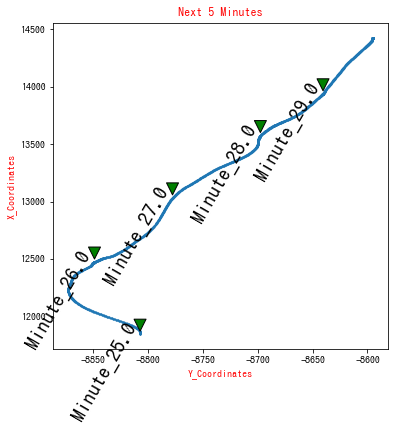

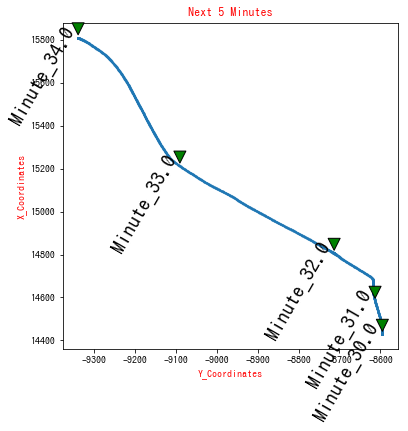

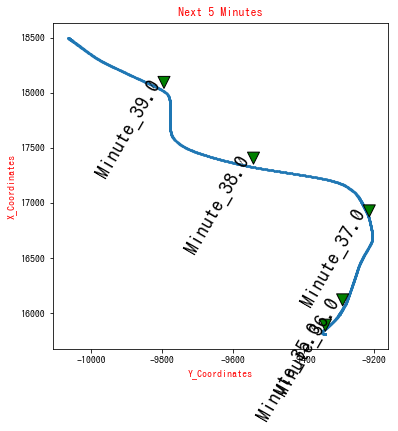

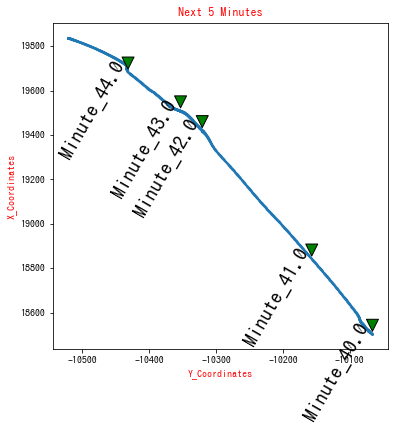

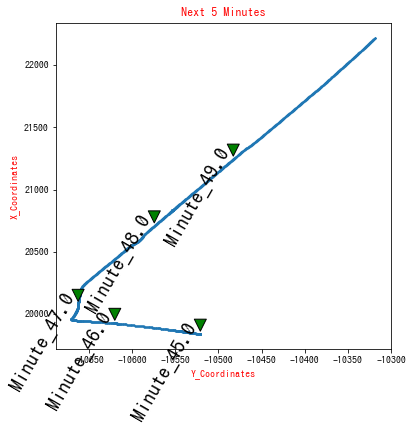

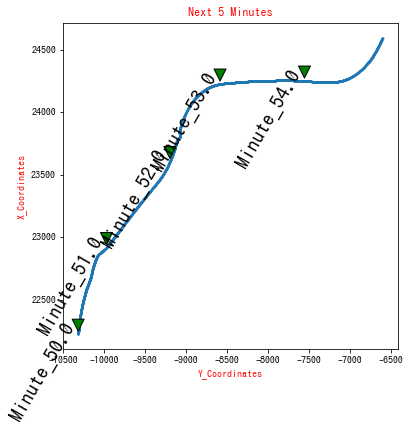

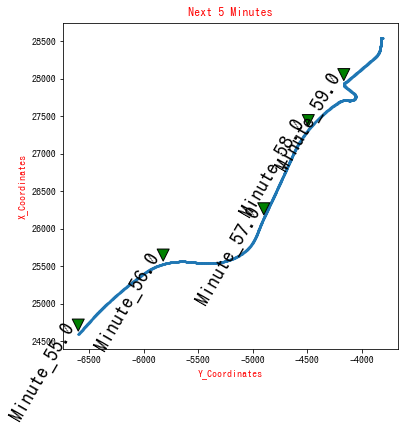

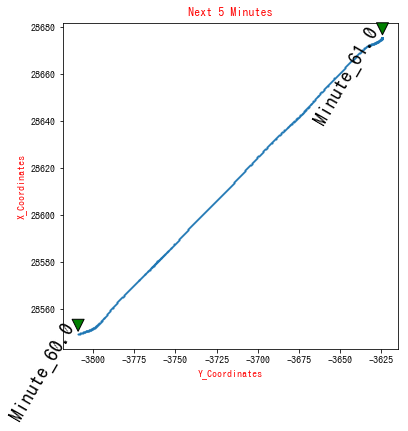

In [31]:
# plot geo map every 5 minutes
unitMinute = 5
nrowCoordinate = len(dfCoordinate.index)
lenUnit = 10*60*unitMinute
pointsStart = np.arange(start = 0, stop = math.floor(nrowCoordinate/lenUnit)*lenUnit+1, step = lenUnit)
pointsEnd = np.append(pointsStart[1:]-1, nrowCoordinate-1)
for ctPlot in range(len(pointsStart)):
    dfCoordinateSegment = dfCoordinate.iloc[pointsStart[ctPlot]:pointsEnd[ctPlot], :]
    plt.figure(figsize = (6,6) )
    mapPlot(dfCoordinateSegment,'Next 5 Minutes', myRotation = 60)

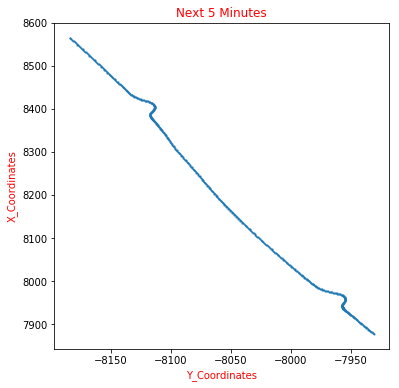

In [36]:
# %%
dfCoordinateSegment = dfCoordinate.iloc[round(10*60*17.5):round(10*60*18.5), :]
plt.figure(figsize = (6,6) )
mapPlot(dfCoordinateSegment,'Next 5 Minutes', myRotation = 60)

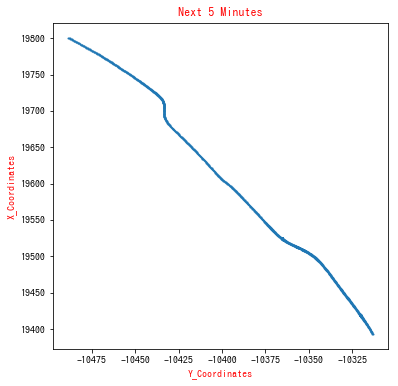

In [32]:
dfCoordinateSegment = dfCoordinate.iloc[round(10*60*41.8):round(10*60*44.5), :]
plt.figure(figsize = (6,6) )
mapPlot(dfCoordinateSegment,'Next 5 Minutes', myRotation = 60)